In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import os
from os import path
import datetime

In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

False
2.0.1


In [4]:
input_dataset = '28_11_2023_21_51_55'

In [5]:
def dataset_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'data', f'{os.path.basename(abs_path)}', timestamp)

In [6]:
dataset_path(input_dataset)

'C:\\Users\\ilona\\OneDrive\\Dokumente\\MCI\\DiBSe\\DiBSE-Sem5\\GesamtProjekt\\TT_git\\tensionterminator\\data\\bodyside_finder\\28_11_2023_21_51_55'

In [7]:
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

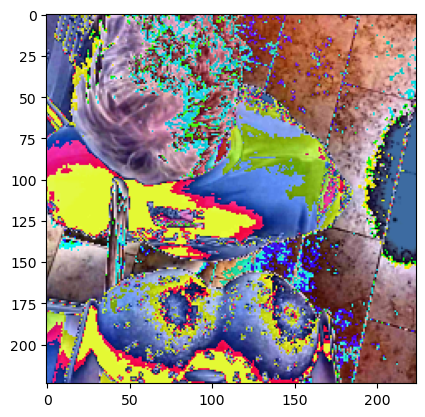

In [8]:
orig_set = datasets.ImageFolder(
    root=dataset_path(input_dataset),
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))


In [9]:
orig_set.classes

['left', 'middle', 'right']

In [10]:
len(orig_set)

10163

In [11]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [12]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [13]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


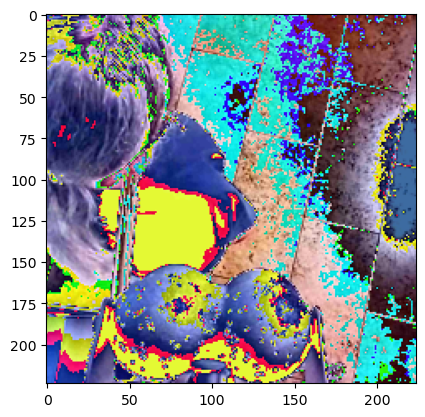

In [14]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [16]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [17]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=8
)

In [18]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

#print(model.fc)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
print(model.fc)

In [18]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,3)
)
#print(model.fc)

In [19]:
#print(model)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [21]:
import os
from os import path
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), '../..'))

from framework.frameworktest_pyt import FrameworkLogger
from framework.main_func import main_train_func

input_args = [train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, device]

# Modell trainieren
logger = FrameworkLogger(5, model, main_train_func, input_args, "bodyside_ResNet152_Weights.IMAGENET1K_V2_8kern")
logger.train_model()
#logger.generate_statistics()

Epoch 0
Epoch: 0: Train: Loss: 0.0498 Acc: 0.8955 Val: Loss: 0.0136 Acc: 0.9478
{'loss': 0.04977204670245649, 'accuracy': 0.895478367805481, 'val_loss': 0.013563836681255199, 'val_accuracy': 0.9478346456692913}
Epoch 0 took 4107.47 seconds
Epoch 1
Epoch: 1: Train: Loss: 0.0225 Acc: 0.9564 Val: Loss: 0.0061 Acc: 0.9813
{'loss': 0.02253713249934385, 'accuracy': 0.9564220309257507, 'val_loss': 0.006137871366802044, 'val_accuracy': 0.9812992125984252}
Epoch 1 took 4096.34 seconds
Epoch 2
Epoch: 2: Train: Loss: 0.0226 Acc: 0.9628 Val: Loss: 0.0029 Acc: 0.9936
{'loss': 0.02261737280855041, 'accuracy': 0.962811291217804, 'val_loss': 0.002882700933895394, 'val_accuracy': 0.9936023622047244}
Epoch 2 took 4135.04 seconds
Epoch 3
Epoch: 3: Train: Loss: 0.0188 Acc: 0.9707 Val: Loss: 0.0114 Acc: 0.9813
{'loss': 0.018842101509021665, 'accuracy': 0.970674991607666, 'val_loss': 0.011438861154992918, 'val_accuracy': 0.9812992125984252}
Epoch 3 took 4120.01 seconds
Epoch 4
Epoch: 4: Train: Loss: 0.0052 

start_time = time.time()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)


    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    print(f"Epoch: {epoch}: Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

end_time = time.time()
print("Time:", end_time - start_time)

In [22]:
def get_time():
    return datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [23]:
def model_save_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'models', f'{os.path.basename(abs_path)}', timestamp, f'model_{get_time()}.pt')

In [24]:
model_save_path(input_dataset)

'C:\\Users\\ilona\\OneDrive\\Dokumente\\MCI\\DiBSe\\DiBSE-Sem5\\GesamtProjekt\\TT_git\\tensionterminator\\models\\bodyside_finder\\28_11_2023_21_51_55\\model_29_11_2023_17_41_09.pt'

In [25]:
save_path = model_save_path(input_dataset)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)

test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=4,
    shuffle=True,
    num_workers=16
)

In [26]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

255 8
Test Accuracy: 0.979411780834198


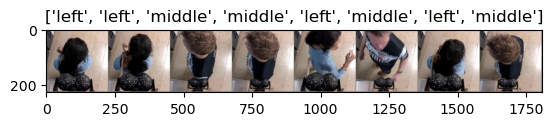

In [27]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()

In [28]:
#starttime 11:55
#endtime
from datetime import datetime

# Get the current timestamp
timestamp = datetime.now()
formatted_timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")
print("Formatted timestamp:", formatted_timestamp)

Formatted timestamp: 2023-11-29 17:48:44
